# TinyML - Graph Convolutional Networks

**Author:** Thommas Kevin Sales Flores  

**Institution:** Federal University of Rio Grande do Norte

**Email:** thommas.flores.101@ufrn.edu.br

This notebook demonstrates an end‑to‑end TinyML workflow using a Graph Convolutional Network (GCN). We use the well‑known Zachary’s Karate Club dataset to illustrate how graph‑structured data can be processed, how a GCN can be trained to classify nodes, and how the trained model can be exported to portable C++ code suitable for embedded devices (e.g., ESP32, Arduino). The notebook is organised into four main parts:

1. **Data Loading and Graph Visualisation** – load the Karate Club graph, inspect its basic properties, and plot its structure with ground‑truth labels.
2. **Model Definition and Training** – define a two‑layer GCN, train it in a semi‑supervised fashion, and monitor training loss and validation accuracy.
3. **Latent Space Visualisation** – extract the hidden node representations produced by the trained GCN and project them into 2D using t‑SNE to assess class separation.
4. **C++ Code Generation** – export the learned weights and graph adjacency matrix to static C++ files that can be compiled and run on microcontrollers.

## Environment Setup

The following commands install the required Python packages. They are commented out by default because the environment may already be configured. If you are running this notebook for the first time, uncomment and execute them to install:

In [3]:
#!pip install -r requirements.txt

## Step 1: Loading the Dataset and Visualising the Graph Topology

We begin by loading the Zachary’s Karate Club dataset using PyTorch Geometric’s built‑in `KarateClub` class. This dataset contains 34 nodes (members of a karate club) and 78 undirected edges (interactions between members). Each node belongs to one of four classes, representing the two factions that emerged after a split in the club. The code below prints basic statistics about the graph and then uses `networkx` to draw the graph, colouring nodes according to their ground‑truth labels. This visualisation helps us understand the structure of the data before applying the GCN.

--- [Step 1] Loading Dataset and Visualizing Topology ---
Number of nodes: 34
Number of edges: 156
Number of classes: 4
Displaying Graph Topology...


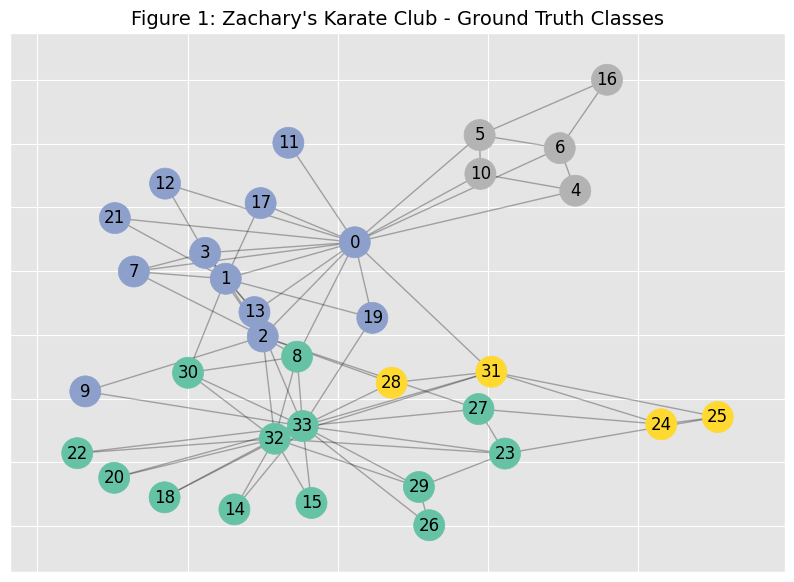

In [16]:
import torch
import json
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch_geometric.datasets import KarateClub
from torch_geometric.utils import to_networkx, to_dense_adj
from torch_geometric.nn import GCNConv
plt.style.use('ggplot')
# ==========================================
# PART 1: DATA LOADING AND TOPOLOGICAL ANALYSIS
# ==========================================

print("--- [Step 1] Loading Dataset and Visualizing Topology ---")

# 1. Dataset Loading
dataset = KarateClub()
data = dataset[0]
data.test_mask = ~data.train_mask


print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Number of classes: {dataset.num_classes}')

# 2. Graph Visualization (NetworkX)
# We convert the PyTorch Geometric data object to a NetworkX graph for plotting.
G = to_networkx(data, to_undirected=True)

plt.figure(figsize=(10, 7))
pos = nx.spring_layout(G, seed=42) # Fixed seed for consistent layout
nx.draw_networkx_nodes(G, pos, node_color=data.y, cmap=plt.get_cmap('Set2'), node_size=500)
nx.draw_networkx_edges(G, pos, alpha=0.3)
nx.draw_networkx_labels(G, pos)
plt.title("Figure 1: Zachary's Karate Club - Ground Truth Classes", fontsize=14)
#plt.axis('off')
print("Displaying Graph Topology...")
plt.show()


## Step 2: Model Definition and Training Loop

We now define a simple two‑layer Graph Convolutional Network. The first layer transforms the input node features (one‑hot vectors) into a 4‑dimensional hidden representation, and the second layer maps these hidden features to the output class logits. ReLU activation is applied after the first convolution.

The model is trained using the Adam optimiser with a learning rate of 0.01. Because the dataset provides a fixed training mask (only a few nodes have labels), we perform semi‑supervised learning: the loss is computed only on the labelled training nodes, while validation accuracy is evaluated on the remaining nodes. Training runs for 200 epochs; loss and validation accuracy are recorded at each epoch for later visualisation.


--- [Step 2] Model Initialization and Training ---
Epoch 000 | Loss: 1.3790 | Val Accuracy: 43.3%
Epoch 050 | Loss: 0.7641 | Val Accuracy: 80.0%
Epoch 100 | Loss: 0.2787 | Val Accuracy: 80.0%
Epoch 150 | Loss: 0.1139 | Val Accuracy: 76.7%
Epoch 200 | Loss: 0.0591 | Val Accuracy: 76.7%
Displaying Training Metrics...


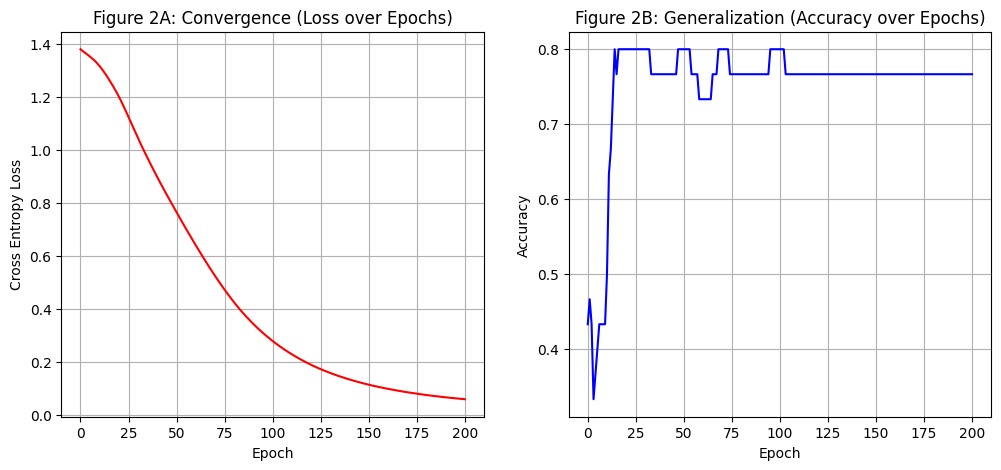

In [ ]:
print("\n--- [Step 2] Model Initialization and Training ---")

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_features, 4)
        self.conv2 = GCNConv(4, dataset.num_classes)

    def forward(self, x, edge_index):
        # Layer 1: Aggregation + ReLU Activation
        x = self.conv1(x, edge_index).relu()
        # Layer 2: Aggregation -> Logits
        x = self.conv2(x, edge_index)
        return x

model = GCN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Metrics Storage
history = {'loss': [], 'accuracy': []}

# Training Loop
for epoch in range(201):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    
    # Compute Loss (Semi-Supervised)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    
    # Validation Step (For Visualization Only)
    model.eval()
    pred = model(data.x, data.edge_index).argmax(dim=1)
    acc = (pred[data.test_mask] == data.y[data.test_mask]).sum().item() / data.test_mask.sum().item()
    
    history['loss'].append(loss.item())
    history['accuracy'].append(acc)
    
    if epoch % 50 == 0:
        print(f"Epoch {epoch:03d} | Loss: {loss.item():.4f} | Val Accuracy: {acc*100:.1f}%")

# 3. Performance Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Loss Curve
ax1.plot(history['loss'], label='Training Loss', color='red')
ax1.set_title("Figure 2A: Convergence (Loss over Epochs)")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Cross Entropy Loss")
ax1.grid(True)

# Accuracy Curve
ax2.plot(history['accuracy'], label='Test Accuracy', color='blue')
ax2.set_title("Figure 2B: Generalization (Accuracy over Epochs)")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.grid(True)

print("Displaying Training Metrics...")
plt.show()

## Step 3: Visualising Learned Embeddings (t‑SNE)

To gain insight into what the GCN has learned, we extract the hidden node representations from the first convolutional layer (after ReLU). These 4‑dimensional vectors are then projected down to two dimensions using t‑SNE, a non‑linear dimensionality reduction technique. The resulting scatter plot (Figure 3) reveals how the model separates the four classes in its internal feature space.


--- [Step 3] Visualizing Learned Embeddings (t-SNE) ---
Displaying Embeddings...


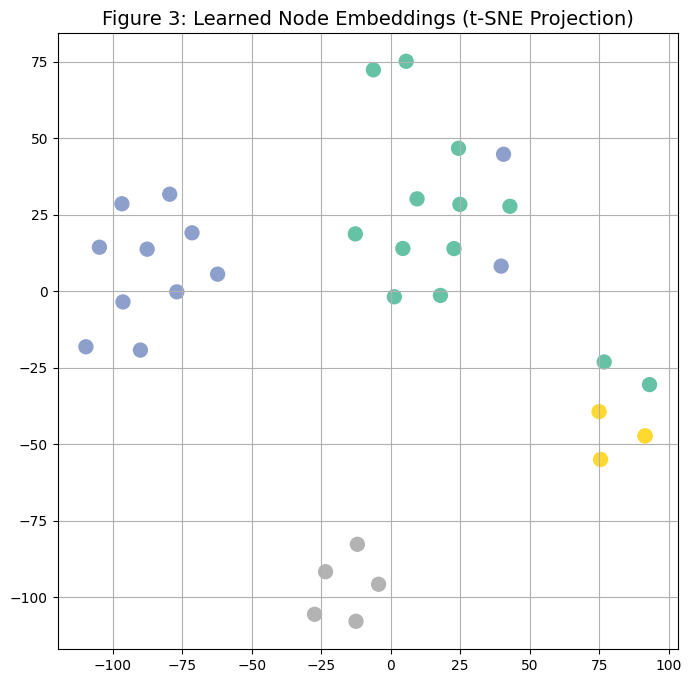

In [ ]:
print("\n--- [Step 3] Visualizing Learned Embeddings (t-SNE) ---")

# Extract the hidden layer representation (the "brain" of the GNN)
model.eval()
# We manually run the first layer to get the embeddings before the final classification
h = model.conv1(data.x, data.edge_index).relu()

# Dimensionality Reduction (4D -> 2D) for plotting
tsne = TSNE(n_components=2, perplexity=10, random_state=42)
z = tsne.fit_transform(h.detach().numpy())

plt.figure(figsize=(8, 8))
plt.scatter(z[:, 0], z[:, 1], s=100, c=data.y, cmap="Set2")
plt.title("Figure 3: Learned Node Embeddings (t-SNE Projection)", fontsize=14)
plt.grid()
print("Displaying Embeddings...")
plt.show()

## Step 4: Generative Phase – Exporting to C++

The final step of this TinyML pipeline is to convert the trained model into a form that can run on embedded hardware. The function `generate_inference_files_safe` extracts the model’s weights, biases, and the adjacency matrix (with self‑loops added) and writes them as static C arrays in two files: `gcn_model.h` and `gcn_model.cpp`. These files contain:

- Constants defining the number of nodes, input features, hidden dimension, and output classes.
- The weight matrices and bias vectors for both GCN layers.
- The adjacency matrix.
- Helper functions (`relu`, `gnn_layer`, `gnn_predict`) that implement the forward pass using only basic arithmetic operations – no external libraries are required.

The generated code can be compiled on platforms like Arduino or ESP32, enabling on‑device inference of the trained GCN.

In [ ]:
print("\n--- [Step 4] Generative Phase: Exporting to C++ ---")

def generate_inference_files_safe(model, data, output_dir="."):
    """
    Extracts model parameters and generates static C++ files (.h and .cpp)
    for inference on embedded systems (e.g., ESP32, Arduino).
    """
    
    state_dict = model.state_dict()
    adj = to_dense_adj(data.edge_index)[0].cpu().numpy()
    adj_with_loops = adj + np.eye(adj.shape[0])
    
    params = {
        "w1": state_dict['conv1.lin.weight'].cpu().numpy().tolist(),
        "b1": state_dict['conv1.bias'].cpu().numpy().tolist(),
        "w2": state_dict['conv2.lin.weight'].cpu().numpy().tolist(),
        "b2": state_dict['conv2.bias'].cpu().numpy().tolist(),
        "adj": adj_with_loops.tolist(),
        "features": data.x.numpy().tolist(),
        "labels": data.y.numpy().tolist(),
        "num_nodes": int(data.num_nodes),
        "in_features": int(dataset.num_features),
        "hidden_dim": 4,
        "out_classes": int(dataset.num_classes)
    }

    def to_c_array(matrix, name, type="float"):
        if isinstance(matrix, list) and isinstance(matrix[0], list): # 2D
            flat = [f"{val:.6f}" for row in matrix for val in row]
            size_str = f"[{len(matrix)}][{len(matrix[0])}]"
        elif isinstance(matrix, list): # 1D
            if type == "int":
                flat = [str(val) for val in matrix]
            else:
                flat = [f"{val:.6f}" for val in matrix]
            size_str = f"[{len(matrix)}]"
        content = ", ".join(flat)
        return f"const {type} {name}{size_str} = {{{content}}};\n"

    h_content = f"""
#ifndef GNN_MODEL_H
#define GNN_MODEL_H

#define NUM_NODES {params['num_nodes']}
#define IN_FEATURES {params['in_features']}
#define HIDDEN_DIM {params['hidden_dim']}
#define OUT_CLASSES {params['out_classes']}

extern const float GNN_W1[HIDDEN_DIM][IN_FEATURES];
extern const float GNN_B1[HIDDEN_DIM];
extern const float GNN_W2[OUT_CLASSES][HIDDEN_DIM];
extern const float GNN_B2[OUT_CLASSES];
extern const float GNN_ADJ[NUM_NODES][NUM_NODES];

// Validation Data
extern const float GNN_REAL_X[NUM_NODES][IN_FEATURES];
extern const int GNN_REAL_Y[NUM_NODES];

void gnn_predict(const float input_features[NUM_NODES][IN_FEATURES], int output_classes[NUM_NODES]);

#endif
"""

    cpp_content = f"""
#include "gcn_model.h"
#include <Arduino.h>

{to_c_array(params['w1'], "GNN_W1")}
{to_c_array(params['b1'], "GNN_B1")}
{to_c_array(params['w2'], "GNN_W2")}
{to_c_array(params['b2'], "GNN_B2")}
{to_c_array(params['adj'], "GNN_ADJ")}

{to_c_array(params['features'], "GNN_REAL_X")}
{to_c_array(params['labels'], "GNN_REAL_Y", type="int")}

float relu(float x) {{ return (x > 0) ? x : 0; }}

void gnn_layer(const float* X, int in_dim, const float* W, const float* B, int out_dim, float* Output) {{
    float linear_temp[NUM_NODES][HIDDEN_DIM > OUT_CLASSES ? HIDDEN_DIM : OUT_CLASSES];

    // Linear Transformation
    for(int i=0; i<NUM_NODES; i++) {{
        for(int j=0; j<out_dim; j++) {{
            float sum = 0;
            for(int k=0; k<in_dim; k++) {{
                sum += X[i*in_dim + k] * W[j*in_dim + k];
            }}
            linear_temp[i][j] = sum + B[j];
        }}
    }}

    // Aggregation
    for(int i=0; i<NUM_NODES; i++) {{
        for(int j=0; j<out_dim; j++) {{
            float sum = 0;
            for(int k=0; k<NUM_NODES; k++) {{
                if(GNN_ADJ[i][k] > 0) {{
                    sum += GNN_ADJ[i][k] * linear_temp[k][j];
                }}
            }}
            Output[i*out_dim + j] = sum;
        }}
    }}
}}

void gnn_predict(const float input_features[NUM_NODES][IN_FEATURES], int output_classes[NUM_NODES]) {{
    static float h1[NUM_NODES][HIDDEN_DIM];
    gnn_layer((const float*)input_features, IN_FEATURES, (const float*)GNN_W1, GNN_B1, HIDDEN_DIM, (float*)h1);
    
    for(int i=0; i<NUM_NODES; i++) 
        for(int j=0; j<HIDDEN_DIM; j++) 
            h1[i][j] = relu(h1[i][j]);

    static float h2[NUM_NODES][OUT_CLASSES];
    gnn_layer((const float*)h1, HIDDEN_DIM, (const float*)GNN_W2, GNN_B2, OUT_CLASSES, (float*)h2);

    for(int i=0; i<NUM_NODES; i++) {{
        int best = 0;
        float max_val = h2[i][0];
        for(int c=1; c<OUT_CLASSES; c++) {{
            if(h2[i][c] > max_val) {{
                max_val = h2[i][c];
                best = c;
            }}
        }}
        output_classes[i] = best;
    }}
}}
"""
    
    with open(f"{output_dir}/gcn_model.h", "w") as f: f.write(h_content)
    with open(f"{output_dir}/gcn_model.cpp", "w") as f: f.write(cpp_content)
    print("Files 'gcn_model.h' and 'gcn_model.cpp' generated successfully.")

# Execute Export
generate_inference_files_safe(model, data)


--- [Step 4] Generative Phase: Exporting to C++ ---
Files 'gcn_model.h' and 'gcn_model.cpp' generated successfully.
